In [1]:
import cebra
import numpy as np
import matplotlib.pyplot as plt
CC_TL = np.load('./data_NER/Fig8/Type: curve-straight=[38]_parameters_5000itr_lr0.0001.npz')
CC_TR = np.load('./data_NER/Fig8/Type: curve-straight=[18]_parameters_5000itr_lr0.0001.npz')
CC_BR = np.load('./data_NER/Fig8/Type: curve-straight=[13]_parameters_5000itr_lr0.0001.npz')
CC_3angle = np.load('./data_NER/Fig8/Type: curve-straight=[13, 38, 18]_parameters_5000itr_lr0.0001.npz')
%matplotlib notebook
dur = 100
plot_dur = 100
output_dimension = 3

arrays_list = [CC_TL['cebra_veldir_train'], CC_TR['cebra_veldir_train'], 
               CC_BR['cebra_veldir_train'], CC_3angle['cebra_veldir_train']]
emb_train_all = np.array(arrays_list, dtype=object)
arrays_list = [CC_TL['target_angle_train'], CC_TR['target_angle_train'], 
               CC_BR['target_angle_train'], CC_3angle['target_angle_train']]
tar_angle_train_all = np.array(arrays_list, dtype=object)
arrays_list = [CC_TL['continuous_index_train'], CC_TR['continuous_index_train'], 
               CC_BR['continuous_index_train'], CC_3angle['continuous_index_train']]
continuous_index_train_all = np.array(arrays_list, dtype=object)
arrays_list = [CC_TL['version_index_train'], CC_TR['version_index_train'], 
               CC_BR['version_index_train'], CC_3angle['version_index_train']]
version_index_train_all = np.array(arrays_list, dtype=object)

<IPython.core.display.Javascript object>


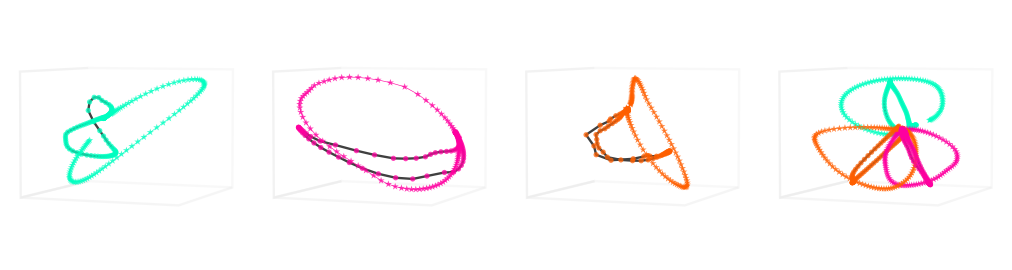

In [2]:
idx1, idx2, idx3 = 0, 1, 2
fig = plt.figure(figsize=(6, 1.6), dpi = 150 )
plt.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)
for i in range(4):
    cebra_veldir_train = emb_train_all[i]
    target_angle_train = tar_angle_train_all[i]
    version_index_train = version_index_train_all[i]
    ax = fig.add_subplot(1, 4, i + 1, projection='3d')
    for i in np.unique(target_angle_train):  ###### version 0
        version_trial = version_index_train ==0
        direction_trial = target_angle_train == i
        trial_raw = cebra_veldir_train[version_trial & direction_trial, :] ### (Xtrials*100bin, 3emb)
        trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)## average over trials>(100bin,3emb)
        ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
                   marker='o',color=plt.cm.hsv(0.00+1 / 360 * i),edgecolors='none',alpha=0.75,s=5)
        ax.plot(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
            color='black',linewidth=1,alpha=0.75)

    for i in np.unique(target_angle_train):  ###### version 1&2
        version_trial = version_index_train >0
        direction_trial = target_angle_train == i
        trial_raw = cebra_veldir_train[version_trial & direction_trial, :] ### (Xtrials*100bin, 3emb)
        trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)## average over trials>(100bin,3emb)
        ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
                   marker='*',color=plt.cm.hsv(1 / 360 * i),edgecolors='none',alpha=0.75,s=10)
        ax.plot(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
            color=plt.cm.hsv(1 / 360 * i),linewidth=0.25,alpha=1) ## 
    ax.set_facecolor('white')  # Set the background color to white
    ax.grid(False)             # Remove the grid
    ax.xaxis.pane.fill = False # Remove the background panes
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ## ax.axis("off") ## remove everything
    ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Remove the axis lines
    ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis.line.set_linewidth(0)
    ax.view_init(elev=4, azim=22)  # Adjust elev and azim for your desired angle
    plt.show()
    plt.savefig('./NER_Figs_pdf/Fig8/Type: straight-curve_embedding.pdf')

<IPython.core.display.Javascript object>


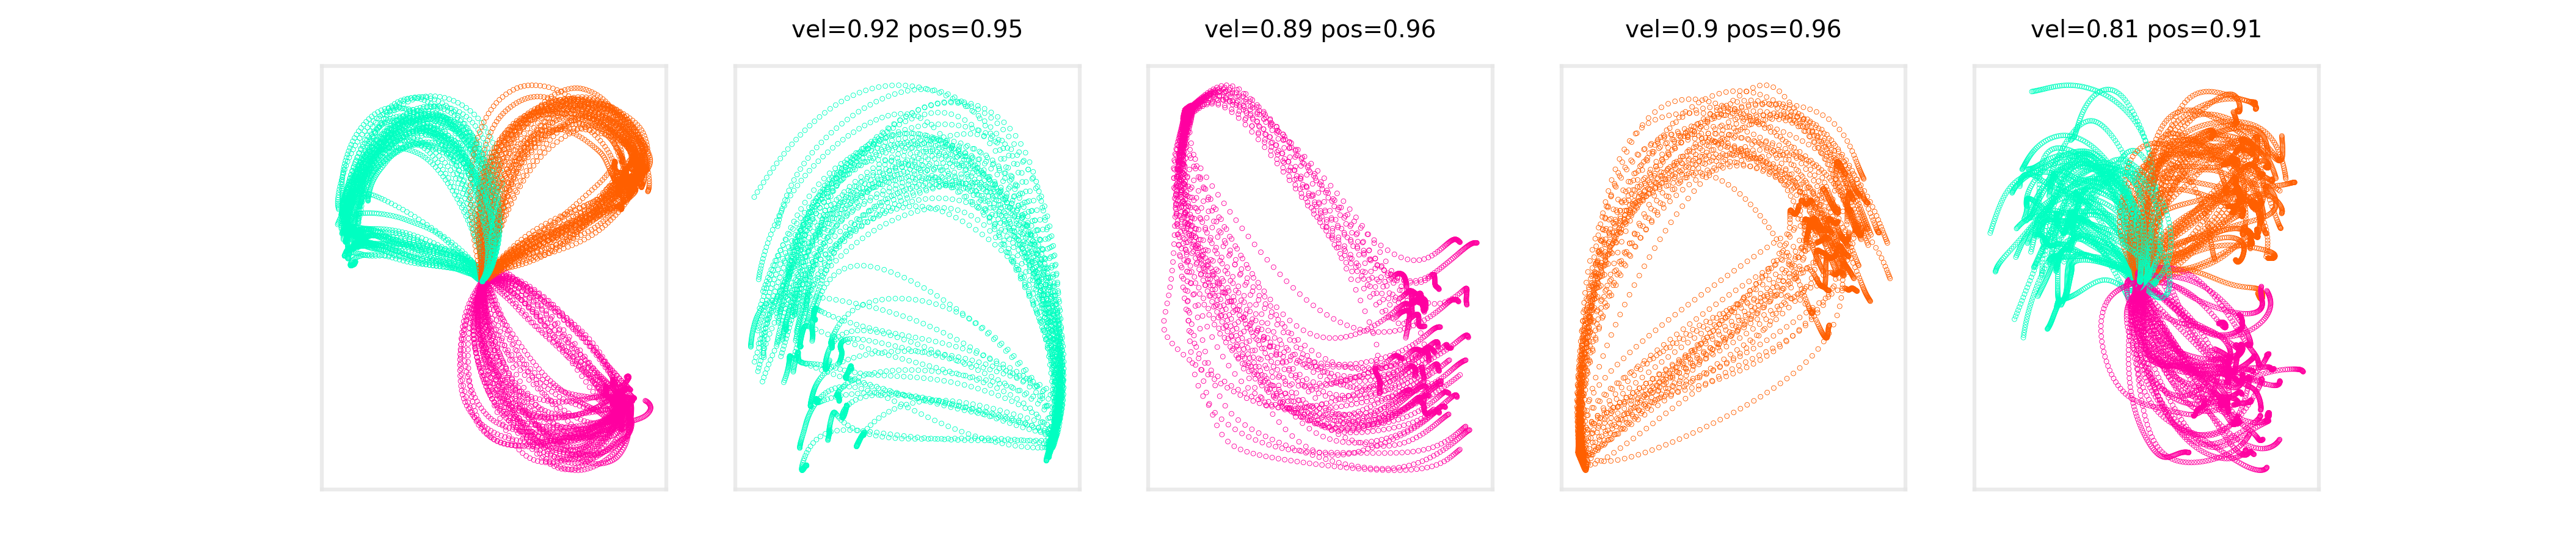

In [3]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics

idx1, idx2, idx3 = 0, 1, 2
fig = plt.figure(figsize=(7.5, 1.6), dpi=500)
# plt.subplots_adjust(wspace=0.2, hspace=0.1, top=1, bottom=0, left=0, right=1)
plt.subplots_adjust(wspace=0.2)
ax = fig.add_subplot(1, 5, 1)
cebra_veldir_train = emb_train_all[3]
continuous_index_train = continuous_index_train_all[3]
target_angle_train = tar_angle_train_all[3]
version_index_train = version_index_train_all[3]

train_trial = int(continuous_index_train.shape[0]/dur)
velocity_reshaped=continuous_index_train[:,0:2].reshape(train_trial,dur,2) ##(Xtrials*100bin,2)to(Xtrials,100bin,2)
locations = np.cumsum(velocity_reshaped/1000, axis=1) ## (Xtrials,100bin,2velocity>>location)
truth_XY = locations.reshape(train_trial*dur, 2) ## (Xtrials*100bin, 2=XY position)
truth_target = target_angle_train ## (Xtrials*100bin,) unique values are [0, 1, 2, 3, 4, 5, 6, 7]

X = cebra_veldir_train
y = continuous_index_train[:, 0:2]
reg = LinearRegression().fit(X, y) 
pred_vel = reg.predict(X) 
velocity_reshaped = pred_vel.reshape(train_trial, dur, 2)
locations = np.cumsum(velocity_reshaped/1000, axis=1)
pred_XY = locations.reshape(train_trial*dur, 2) ## (dur*number of trials, 2=XY position)

posi_r2 = sklearn.metrics.r2_score(truth_XY, pred_XY) ### proportion of total variation explained by model
vel_r2 = sklearn.metrics.r2_score(continuous_index_train[:, 0:2], pred_vel)

trial_version_train = version_index_train ==0
norm = plt.Normalize(vmin=0, vmax=1)
ax.scatter(truth_XY[trial_version_train, 0], truth_XY[trial_version_train, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(0.00+1/360*truth_target[trial_version_train]), s=0.05)
trial_version_train = version_index_train >0
ax.scatter(truth_XY[trial_version_train, 0], truth_XY[trial_version_train, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(1/360*truth_target[trial_version_train]), s=0.05)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['bottom'].set_color((0.9, 0.9, 0.9, 0.8))
ax.spines['top'].set_color((0.9, 0.9, 0.9, 0.8))
ax.spines['right'].set_color((0.9, 0.9, 0.9, 0.8))
ax.spines['left'].set_color((0.9, 0.9, 0.9, 0.8))

for i in range(4):
    cebra_veldir_train = emb_train_all[i]
    continuous_index_train = continuous_index_train_all[i]
    target_angle_train = tar_angle_train_all[i]
    version_index_train = version_index_train_all[i]
    ax = fig.add_subplot(1, 5, i + 2)
    
    train_trial = int(continuous_index_train.shape[0]/dur)
    velocity_reshaped=continuous_index_train[:,0:2].reshape(train_trial,dur,2) ##(Xtrials*100bin,2)to(Xtrials,100bin,2)
    locations = np.cumsum(velocity_reshaped/1000, axis=1) ## (Xtrials,100bin,2velocity>>location)
    truth_XY = locations.reshape(train_trial*dur, 2) ## (Xtrials*100bin, 2=XY position)
    truth_target = target_angle_train ## (Xtrials*100bin,) unique values are [0, 1, 2, 3, 4, 5, 6, 7]

    X = cebra_veldir_train
    y = continuous_index_train[:, 0:2]
    reg = LinearRegression().fit(X, y) ### n_jobs = 8 >>> unnecessary
    pred_vel = reg.predict(X) 
    velocity_reshaped = pred_vel.reshape(train_trial, dur, 2)
    locations = np.cumsum(velocity_reshaped/1000, axis=1)
    pred_XY = locations.reshape(train_trial*dur, 2) ## (dur*number of trials, 2=XY position)

    posi_r2 = sklearn.metrics.r2_score(truth_XY, pred_XY) ### proportion of total variation explained by model
    vel_r2 = sklearn.metrics.r2_score(continuous_index_train[:, 0:2], pred_vel)

    trial_version_train = version_index_train ==0
    ax.scatter(pred_XY[trial_version_train, 0], pred_XY[trial_version_train, 1], alpha=1, marker='.', 
                color=plt.cm.hsv(0.00+1/360*truth_target[trial_version_train]), s=0.05)
    trial_version_train = version_index_train >0
    ax.scatter(pred_XY[trial_version_train, 0], pred_XY[trial_version_train, 1], alpha=1, marker='.', 
                color=plt.cm.hsv(1/360*truth_target[trial_version_train]), s=0.05)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['bottom'].set_color((0.9, 0.9, 0.9, 0.8))
    ax.spines['top'].set_color((0.9, 0.9, 0.9, 0.8))
    ax.spines['right'].set_color((0.9, 0.9, 0.9, 0.8))
    ax.spines['left'].set_color((0.9, 0.9, 0.9, 0.8))
    plt.title('vel='+str(round(vel_r2, 2))+' pos='+str(round(posi_r2, 2)), fontsize=5)
    plt.savefig('./NER_Figs_pdf/Fig8/Type: straight-curve_var.pdf')